# Машинное обучение, ФКН ВШЭ

## Отбор признаков с помощью стандартных и не очень методов

### Введение

Основные методы отбора признаков и/или понижения размерности описаны [вот в этом ноутбуке](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/seminars/sem12_pca_tsne.ipynb). Сейчас мы поговорим про другие, чуть более необычные, варианты.

Давайте будем использовать для наших опытов данные Fashion MNIST. Так как это датасет, в котором мы будем решать задачу классификации, просто посчитать какой-либо коэффициент корреляции у нас не выйдет (разве что мы будем ошибочно считать метку класса целочисленной переменной, несущей какой-то стандартный численный смысл, что, конечно, неправда). Вместо этого мы предложим другой вариант, также имеющий право на существование, и сравним его с генетическим алгоритмом. Давайте скачаем нужные данные и библиотеки:

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

4422102/4422102 [==============================] - 1s 0us/step


Посмотрим, сколько у нас всего признаков для каждого объекта:

In [2]:
x_train.shape

(60000, 784)

Так, отлично, у нас целых 784 признака. Тут явно есть из чего отбирать! Давайте для начала посмотрим, как справляется самая обычная логистическая регрессия с параметрами по умолчанию, чтобы в будущем потерять, насколько плачевны наши потери в качестве модели:

In [3]:
start_logreg = LogisticRegression()
start_logreg.fit(x_train, y_train)
baseline = accuracy_score(y_test, start_logreg.predict(x_test))
baseline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8412

### Быстрый отбор

Окей, теперь давайте используем некоторые быстрые методы отбора признаков и посмотрим, какого качества мы можем добиться. Давайте просто используем каждый признак по отдельности и отсортируем их по качеству обученных на них моделей, после чего будем брать только несколько самых лучших по данному показателю признаков для обучения.

In [ ]:
feature_accs = []
for i in tqdm(range(x_train.shape[1])):
    x_p_train = []
    for x in x_train[:, i]:
        x_p_train.append([x])
    x_p_test = []
    for x in x_test[:, i]:
        x_p_test.append([x])
    lr = LogisticRegression()
    lr.fit(x_p_train, y_train)
    feature_accs.append(accuracy_score(y_test, lr.predict(x_p_test)))

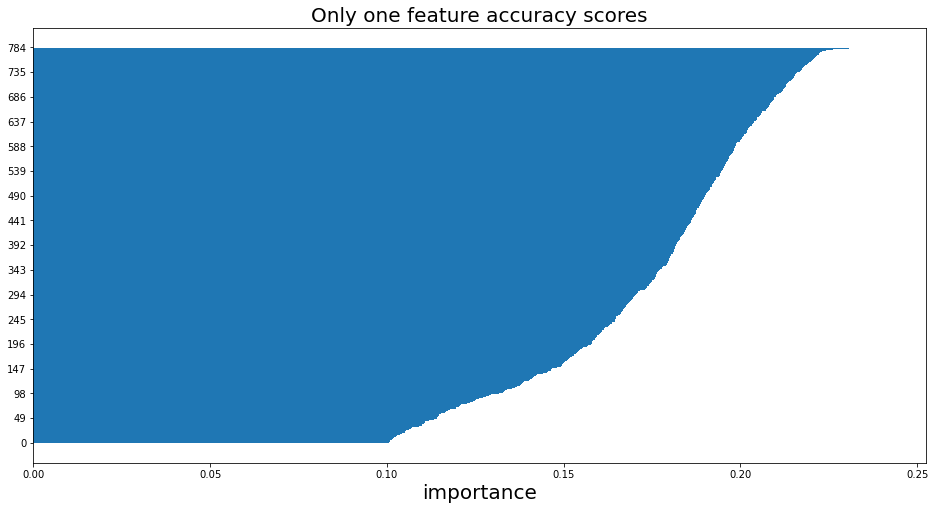

In [68]:
fig = plt.figure(figsize = (16, 8))
plt.barh(np.arange(x_train.shape[1]), sorted(feature_accs), height = 1)
plt.title('Only one feature accuracy scores', fontsize = 20)
plt.xlabel('importance', fontsize = 20)
plt.yticks(np.arange(0, 785, 49))
accuracy_sort = np.argsort(feature_accs)
X = x_train[:, accuracy_sort]
Xt = x_test[:, accuracy_sort]

Что ж, самый успешный признак в одиночку выдал что-то около 0.225, а самый неуспешный – 0.1. Давайте теперь попробуем взять лучшие группы признаков разного размера и посмотреть, как при этом меняется качество модели:

In [192]:
features_counts = np.arange(0, X.shape[1], 49)

def scores_by_features_count(features_counts = np.arange(0, X.shape[1], 49)):
    scores = []
    times = []
    for features_part in features_counts:
        start = time.time()
        reg = LogisticRegression()
        X_part = X[:, features_part:]
        X_part_test = Xt[:, features_part:]
        reg.fit(X_part, y_train)
        scores.append(accuracy_score(y_test, reg.predict(X_part_test)))
        end = time.time()
        times.append(end - start)
    return scores, times

logreg_scores, logreg_times = scores_by_features_count()

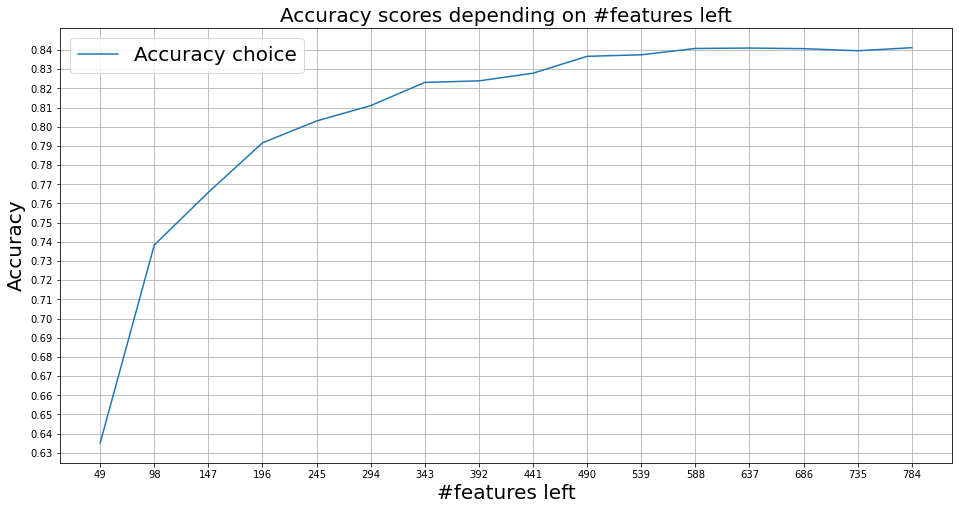

In [182]:
plt.figure(figsize = (16, 8))
plt.plot(784 - features_counts, logreg_scores, label = 'Accuracy choice')
plt.title('Accuracy scores depending on #features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(784 - features_counts)
plt.yticks(np.arange(0.63, 0.85, 0.01))
plt.grid()

Как можно увидеть, можно смело убрать почти 200 самых незначимых по нашему простенькому бенчмарку признаков, и точность модели останется не ниже 0.84 (так как в тестовой выборке у нас 10000 объектов, это значит, что после отбора признаков мы ошиблись максимум на 12 раз больше, то есть точность упала где-то на 0.14%), это впечатляет. Давайте глянем на время работы наших моделей:

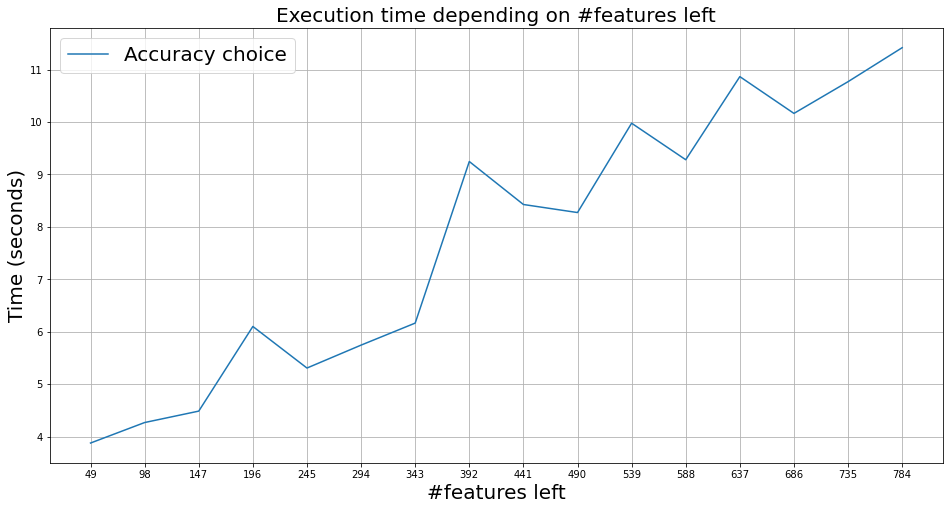

In [183]:
plt.figure(figsize = (16, 8))
plt.plot(784 - features_counts, logreg_times, label = 'Accuracy choice')
plt.title('Execution time depending on #features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Time (seconds)', fontsize = 20)
plt.xticks(784 - features_counts)
plt.grid()

Такую зависимость с некоторой натяжкой можно назвать примерно линейной, так что убрать четверть признаков – это мощно (из графика видно, что модель стала работать примерно на 20% быстрее). Но теперь, когда мы знаем, с чем соревноваться, перейдём к более интересной части.

### Генетический алгоритм

Давайте напишем генетический алгоритм. Нашей функцией приспособленности, очевидно, будет являться точность на тесте (чем больше, тем выше шансы выжить), мы будем использовать скрещивание (если признак есть у обоих родителей, мы его точно берём, из остальных добираем равновероятно до нужного числа), размер популяции будем брать таким, чтобы каждый признак был в среднем у четырёх особей. На каждом шаге скрещивания будем отбирать и скрещивать $ 2/7 $ особей (у каждой пары родителей рождается один ребёнок), увеличивая популяцию в $ 8/7 $ раза, после чего убирать $ 1/8 $ самых неудачливых (таким образом, размер популяции не меняется на протяжении всего процесса обучения). Останавливаться будем, когда разность лучшей и худшей точностей будет признана незначительной:

In [6]:
def generate(select = 784, n_features = 784):
    population = n_features // select * 4
    species = []
    for _ in range(population):
        species.append(np.random.choice(n_features, size = select, replace = False))
    return np.array(species)

def calc_accs(species = []):
    accs = []
    for specy in species:
        reg = LogisticRegression()
        x_part_train = x_train[:, specy]
        x_part_test = x_test[:, specy]
        reg.fit(x_part_train, y_train)
        accs.append(accuracy_score(y_test, reg.predict(x_part_test)))
    return np.array(accs)

def breed(species = [], accs = [], alpha = 7):
    parents = np.random.choice(species.shape[0], size = species.shape[0] // alpha * 2, replace = False, p = accs / np.sum(accs))
    dads = species[parents[0::2]]
    moms = species[parents[1::2]]
    bind = np.full(shape = (dads.shape[0], x_train.shape[1]), fill_value = False)
    bind[np.arange(bind.shape[0])[:, None], dads] = True
    binm = np.full(shape = (moms.shape[0], x_train.shape[1]), fill_value = False)
    binm[np.arange(binm.shape[0])[:, None], moms] = True
    same = bind * binm
    diff = bind ^ binm
    children = np.empty(shape = dads.shape, dtype = int)
    for i in range(dads.shape[0]):
        det = np.nonzero(same[i])[0]
        if diff[i].any():
            und = np.random.choice(np.nonzero(diff[i])[0], size = dads.shape[1] - det.shape[0], replace = False)
        else:
            und = np.array([], dtype = int)
        child = np.concatenate((det, und))
        if child.shape[0] > children.shape[1]:
            child = child[:children.shape[1]]
        elif child.shape[0] < children.shape[1]:
            temp = np.full(shape = x_train.shape[1], fill_value = 1.0)
            temp[child] = 0.0
            temp /= np.sum(temp)
            add = np.random.choice(temp.shape[0], size = children.shape[1] - child.shape[0], replace = False, p = temp)
            child = np.concatenate((child, add))
        children[i] = child
    new_species = np.concatenate((species, children))
    new_accs = np.concatenate((accs, calc_accs(children)))
    return new_species, new_accs

def selection(species = [], accs = [], alpha = 8):
    if not np.all(accs[:-1] <= accs[1:]):
        order = np.argsort(accs)
        accs = accs[order]
        species = species[order]
    accs = accs[accs.shape[0] // alpha:]
    species = species[species.shape[0] // alpha:]
    return species, accs

def pipeline(select = 784, eps = 0.01):
    species = generate(select)
    accs = calc_accs(species)
    max_accs = [np.amax(accs)]
    min_accs = [np.amin(accs)]
    avg_accs = [np.average(accs)]
    while np.amax(accs) - np.amin(accs) > eps:
        species, accs = breed(species, accs)
        species, accs = selection(species, accs)
        max_accs.append(np.amax(accs))
        min_accs.append(np.amin(accs))
        avg_accs.append(np.average(accs))
    return max_accs, min_accs, avg_accs

Что ж, давайте прогоним наш генетический алгоритм!

In [ ]:
features_counts_gen = np.arange(49, X.shape[1] + 1, 245)

def scores_by_features_count_gen(features_counts_gen = np.arange(49, X.shape[1] + 1, 245), eps = 0.01):
    max_scores = []
    min_scores = []
    avg_scores = []
    times = []
    for features_part in tqdm(features_counts_gen):
        start = time.time()
        all_scores = pipeline(select = features_part, eps = eps)
        end = time.time()
        times.append(end - start)
        max_scores.append(all_scores[0])
        min_scores.append(all_scores[1])
        avg_scores.append(all_scores[2])
    return max_scores, min_scores, avg_scores, times

gen_max_scores, gen_min_scores, gen_avg_scores, gen_times = scores_by_features_count_gen()
best = []
for gen in gen_max_scores:
    best.append(gen[-1])

Так, давайте рисовать:

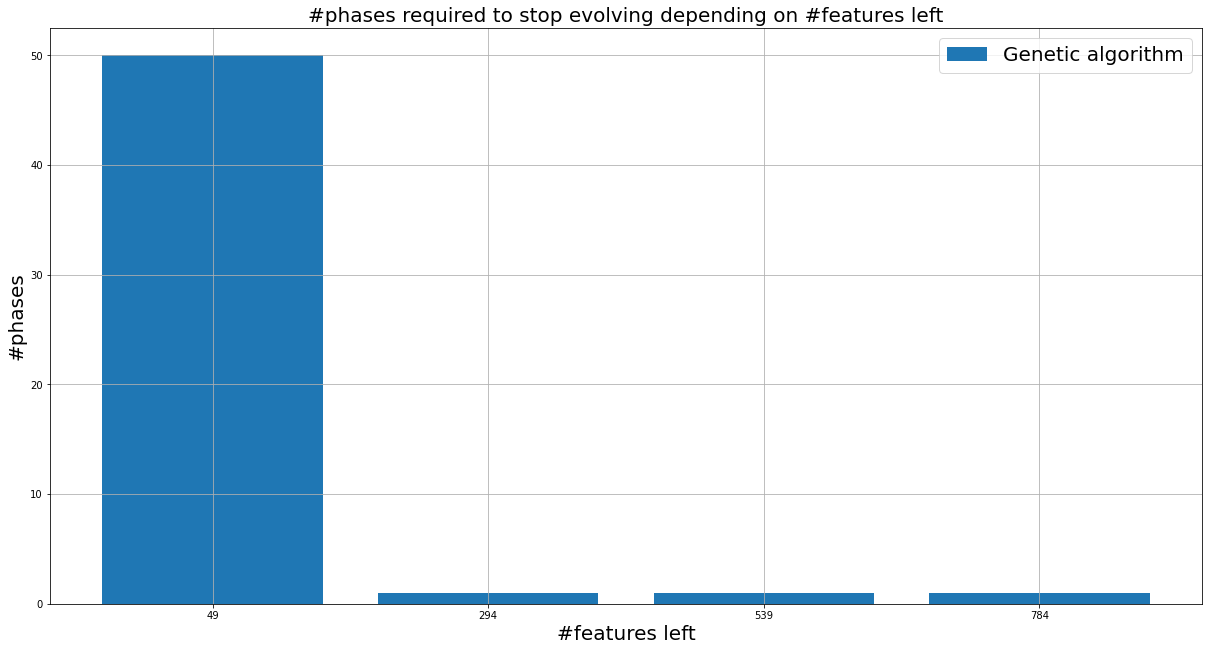

In [78]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_axes([1,1,1,1])
plt.bar(range(len(gen_max_scores)), [len(gen_max) for gen_max in gen_max_scores], label = 'Genetic algorithm')
plt.title('#phases required to stop evolving depending on #features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('#phases', fontsize = 20)
plt.xticks(range(len(gen_max_scores)))
ax.set_xticklabels(features_counts_gen)
plt.grid()

Как видим, параметр остановки, возможно, стоило подбирать более тщательно, так как на трёх тестах из четырёх алгоритму хватило начальной популяции для остановки (впрочем, в случае 784 признаков, то есть фактически отсутствия отбора признаков, все стартовые особи были идентичными, в случае 539 особей было не очень сложно, чтобы все модели вышли более или менее удачными, а вот в случае 294 особей, возможно, присутствовала доля везения). Давайте сравним точности, полученные генетическим алгоритмом, с предыдущим быстрым отбором:

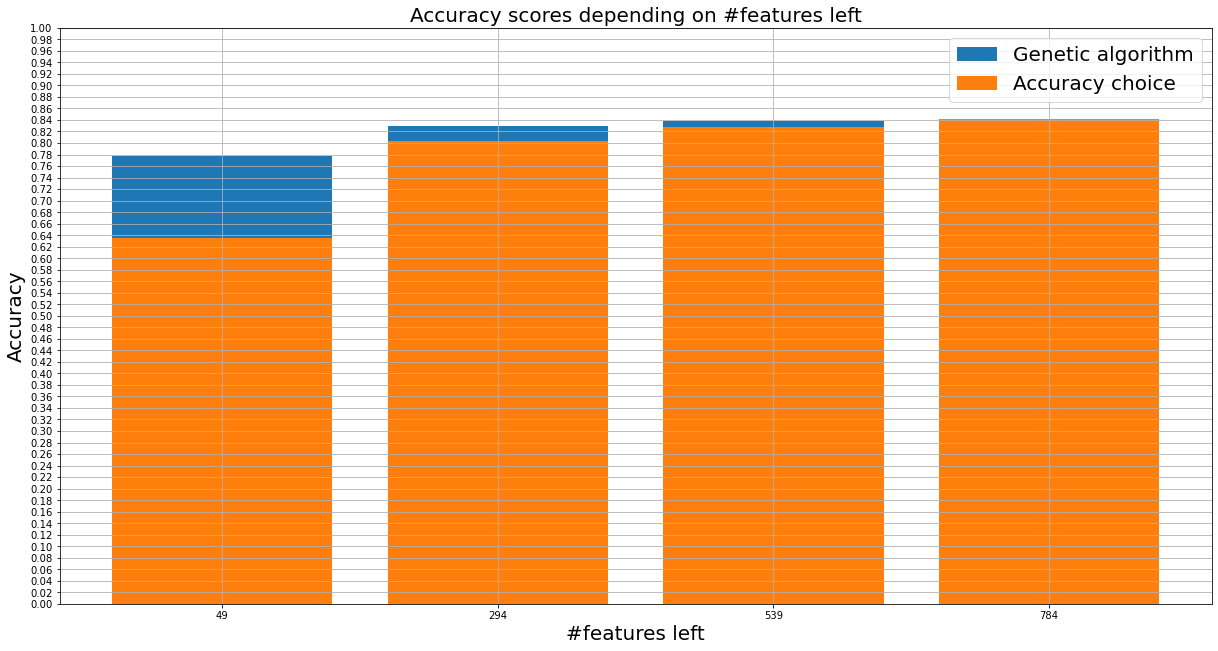

In [188]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_axes([1,1,1,1])
plt.bar(range(len(best)), best, label = 'Genetic algorithm')
plt.bar(range(len(best)), logreg_scores[::-4], label = 'Accuracy choice')
plt.title('Accuracy scores depending on #features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(range(len(best)))
plt.yticks(np.arange(0, 1.02, 0.02))
ax.set_xticklabels(features_counts_gen)
plt.grid()

На 784 признаках, очевидно, достигнуто равенство, зато вот на подмножествах генетический алгоритм справляется лучше, причём тем лучше, чем меньше признаков мы хотим оставить (при этом растёт как абсолютная разница в точности, так и относительная, то есть результат впечатлает с любой точки зрения). Так как всего один алгоритм работал больше, чем одну фазу, давайте посмотрим, как в нём менялись результаты лучшей и худшей из особей и средние результаты по популяции:

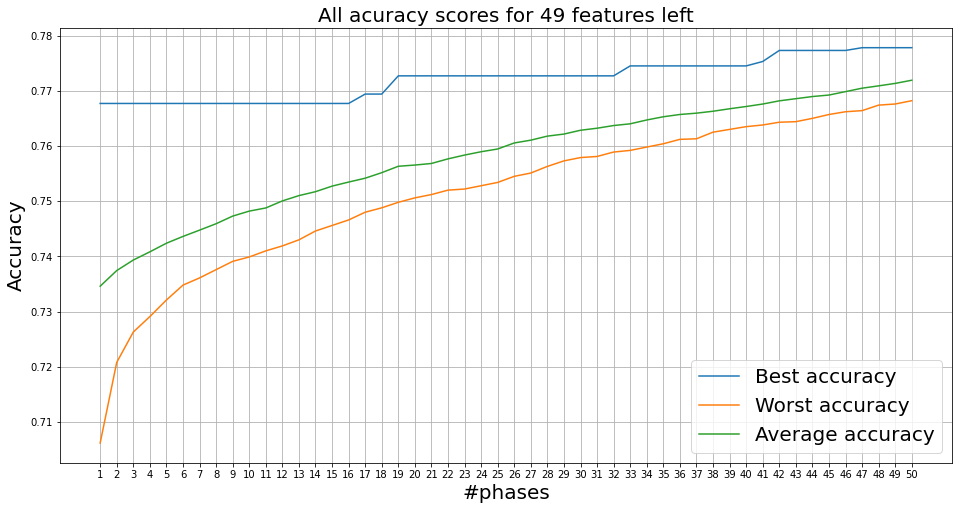

In [79]:
plt.figure(figsize = (16, 8))
plt.plot(range(1, len(gen_max_scores[0]) + 1), gen_max_scores[0], label = 'Best accuracy')
plt.plot(range(1, len(gen_min_scores[0]) + 1), gen_min_scores[0], label = 'Worst accuracy')
plt.plot(range(1, len(gen_avg_scores[0]) + 1), gen_avg_scores[0], label = 'Average accuracy')
plt.title('All acuracy scores for 49 features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#phases', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(range(1, len(gen_max_scores[0]) + 1))
plt.grid()

Как видим, в результате отбора средний и худший результат почти всегда росли, а вот лучшая особь могла не меняться несколько фаз, хотя периодические скачки происходили, и в процессе работы генетического алгоритма лучшая особь смогла вырасти примерно на 0.01, а худшая особь в популяции к концу работы алгоритма справлялась на уровне лучшей особи в его начале. Как видим, идеи генетического алгоритма работают!

Давайте для наглядности ещё немного иначе изобразим график сравнения точностей:

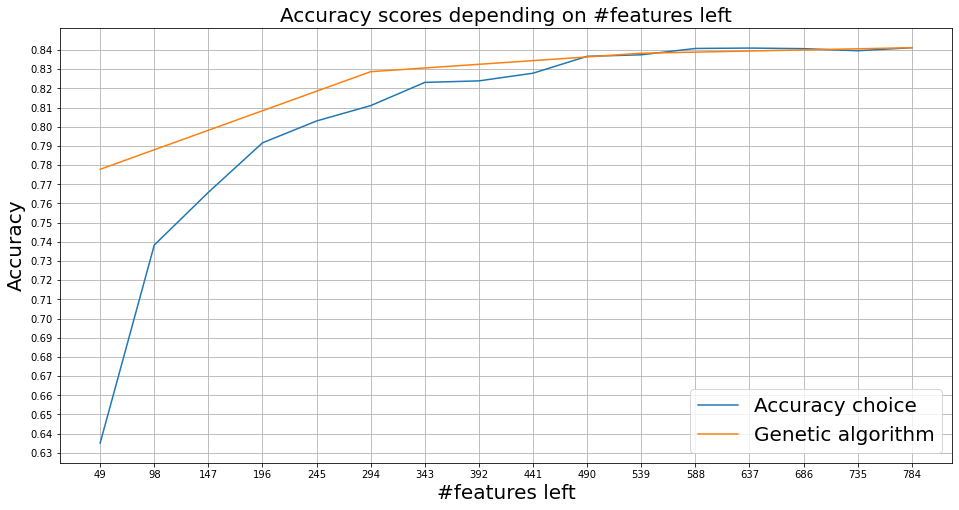

In [190]:
plt.figure(figsize = (16, 8))
plt.plot(784 - features_counts, logreg_scores, label = 'Accuracy choice')
plt.plot(features_counts_gen, best, label = 'Genetic algorithm')
plt.title('Accuracy scores depending on #features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(784 - features_counts)
plt.yticks(np.arange(0.63, 0.85, 0.01))
plt.grid()

Однако, как мы помним, у генетического алгоритма есть один большой минус – время работы. Давайте нарисуем его в логарифмической шкале:

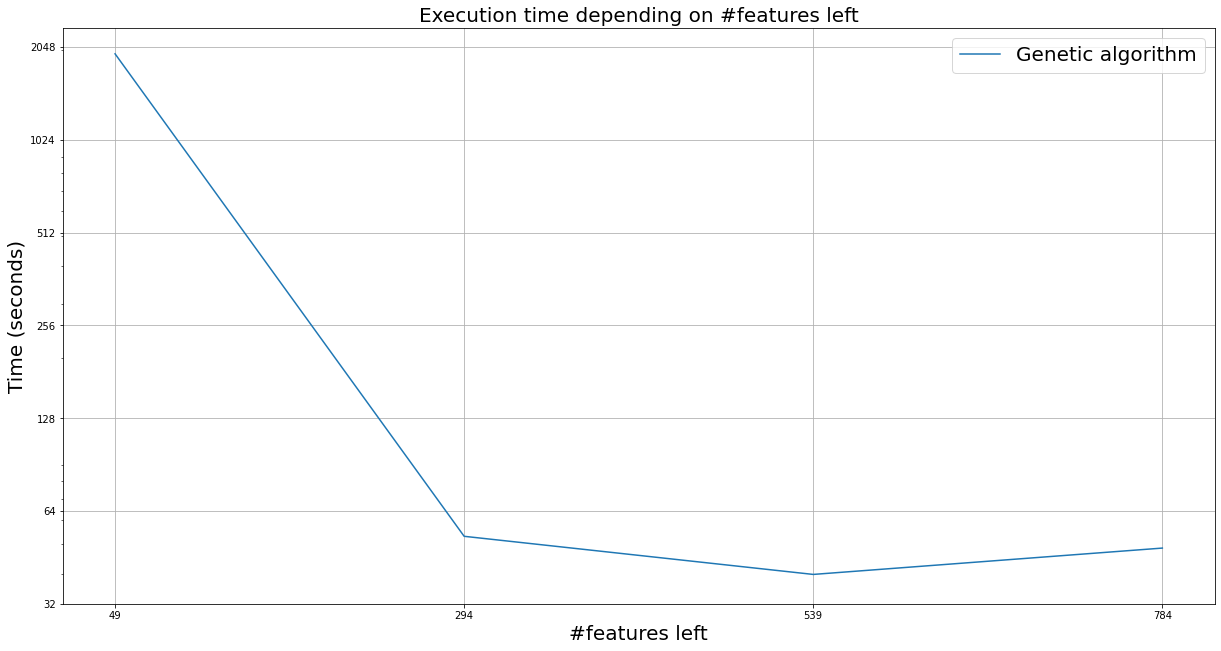

In [95]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_axes([1,1,1,1])
plt.plot(features_counts_gen, gen_times, label = 'Genetic algorithm')
plt.legend(loc = 'best', fontsize = 20)
plt.title('Execution time depending on #features left', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Time (seconds)', fontsize = 20)
plt.xticks(features_counts_gen)
plt.yscale('log')
plt.yticks([2 ** i for i in range(5, 12)])
ax.set_yticklabels([2 ** i for i in range(5, 12)])
plt.grid()

Как мы помним, в случае с 294 и больше признаками алгоритм, фактически, просто сгенерировал случайные подмножества признаков, обучил на них модель и посчитал точности, так что этот график не слишком информативаен. И всё-таки давайте нарисуем соотношение времён, затраченных на отбор признаков:

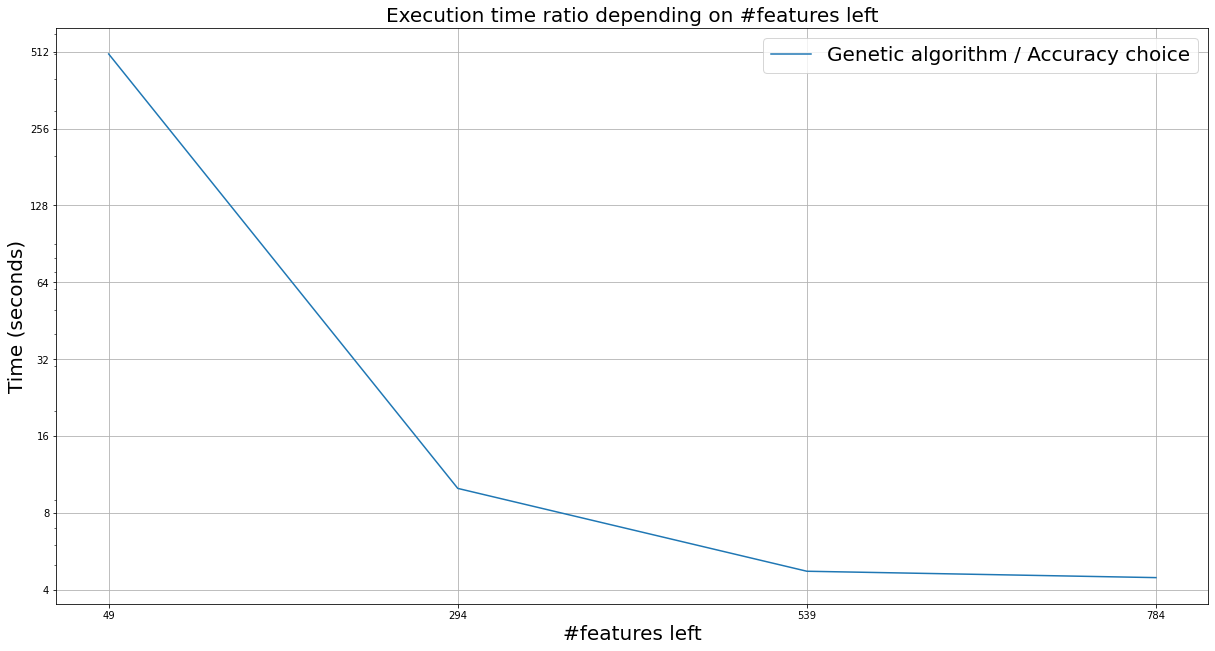

In [191]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_axes([1,1,1,1])
plt.plot(features_counts_gen, np.array(gen_times) / np.array(logreg_times[::-4]), label = 'Genetic algorithm / Accuracy choice')
plt.legend(loc = 'best', fontsize = 20)
plt.title('Execution time ratio depending on #features left', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Time (seconds)', fontsize = 20)
plt.xticks(features_counts_gen)
plt.yscale('log')
plt.yticks([2 ** i for i in range(2, 10)])
ax.set_yticklabels([2 ** i for i in range(2, 10)])
plt.grid()

Как видим, для 49 признаков, где генетический алгоритм дал наибольший прирост, разрыв по времени колоссален: 512 раз! Автор ноутбука очень долго ждал подсчётов.

Как мы заметили, наибольшая разница в результатах наблюдается при малом числе признаков, которые нужно оставить. Давайте попробуем провести в этой области побольше экспериментов и посмотреть, продолжит ли генетический алгоритм побеждать:

In [ ]:
features_counts_last = np.arange(14, 329, 35)

logreg_scores_last, logreg_times_last = scores_by_features_count(784 - features_counts_last)
gen_max_scores_last, gen_min_scores_last, gen_avg_scores_last, gen_times_last = scores_by_features_count_gen(features_counts_last)
best_last = []
for gen in gen_max_scores_last:
    best_last.append(gen[-1])

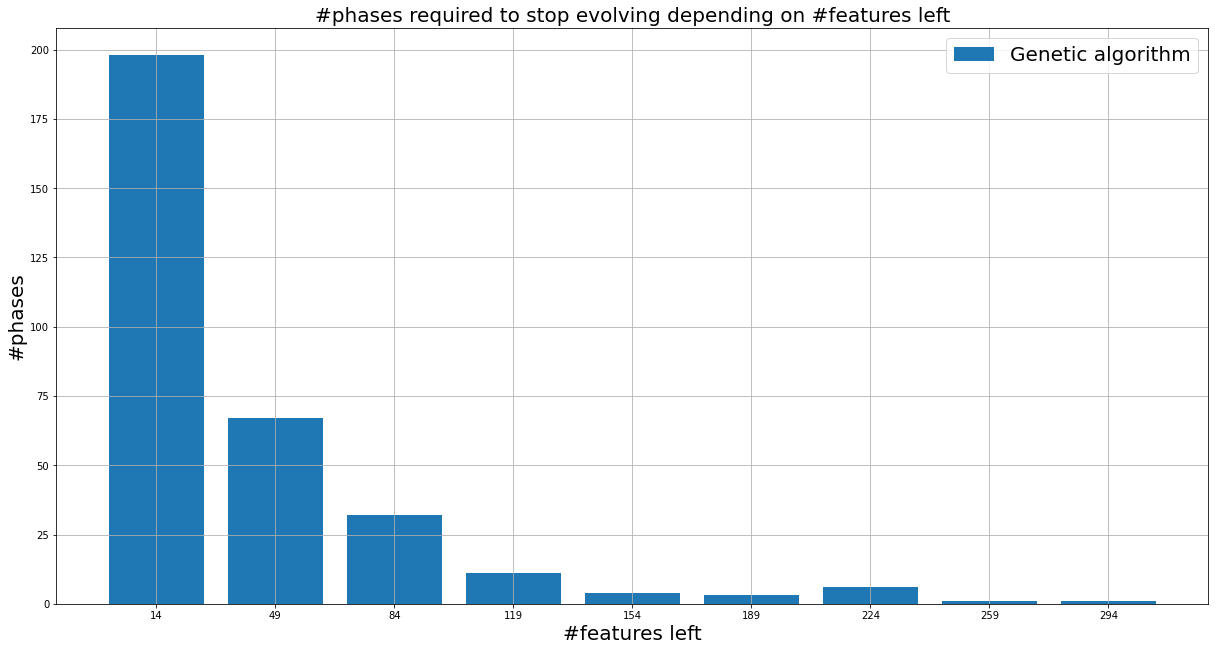

In [99]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_axes([1,1,1,1])
plt.bar(range(len(gen_max_scores_last)), [len(gen_max) for gen_max in gen_max_scores_last], label = 'Genetic algorithm')
plt.title('#phases required to stop evolving depending on #features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('#phases', fontsize = 20)
plt.xticks(range(len(gen_max_scores_last)))
ax.set_xticklabels(features_counts_last)
plt.grid()

Что ж, здесь уже, как видим, в большинстве случаев одной фазы для завершения работы алгоритма не хватило. В целом, количество необходимых фаз монотонно не возрастает с ростом числа оставляемых признаков (есть один выброс, но, как мы помним, генетический алгоритм подвержен случайности, так что такой выброс не удивителен). Перейдём к самому интересному: сравним точности наших методов отбора:

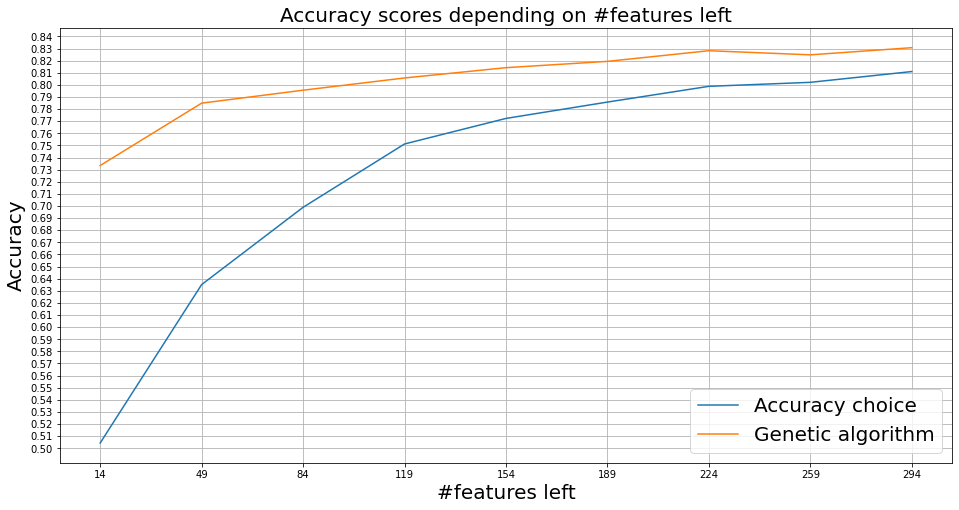

In [197]:
plt.figure(figsize = (16, 8))
plt.plot(features_counts_last, logreg_scores_last, label = 'Accuracy choice')
plt.plot(features_counts_last, best_last, label = 'Genetic algorithm')
plt.title('Accuracy scores depending on #features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(features_counts_last)
plt.yticks(np.arange(0.5, 0.85, 0.01))
plt.grid()

Ну это однозначная победа генетического алгоритма! На 14 признаках из 784 генетический алгоритм умудрился покаазть точность выше 0.73, это очень круто. Тенденция сохранилась: чем меньше признаков надо оставить, тем больший отрыв показывает генетический алгоритм. Но без минусов никуда: вновь взглянем на время:

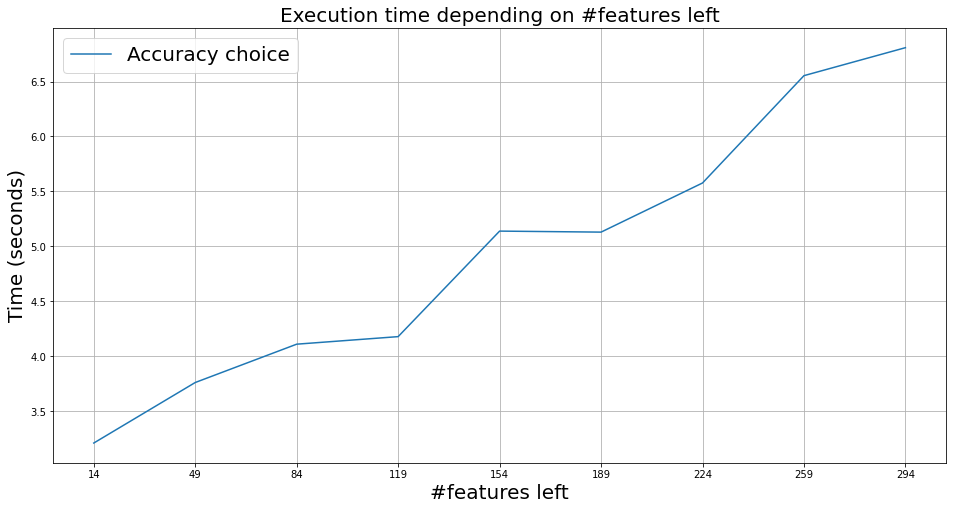

In [198]:
plt.figure(figsize = (16, 8))
plt.plot(features_counts_last, logreg_times_last, label = 'Accuracy choice')
plt.legend(loc = 'best', fontsize = 20)
plt.title('Execution time depending on #features left', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Time (seconds)', fontsize = 20)
plt.xticks(features_counts_last)
plt.grid()

Тут всё понятно, перейдём к самому страшному:

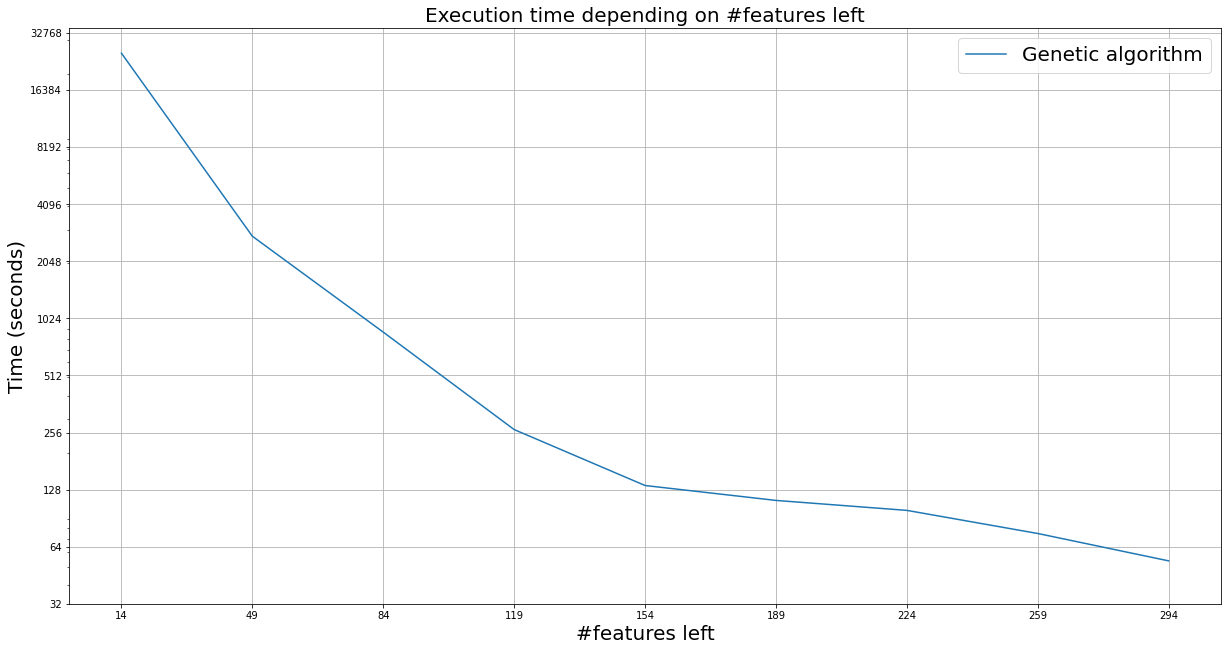

In [105]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_axes([1,1,1,1])
plt.plot(features_counts_last, gen_times_last, label = 'Genetic algorithm')
plt.legend(loc = 'best', fontsize = 20)
plt.title('Execution time depending on #features left', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Time (seconds)', fontsize = 20)
plt.xticks(features_counts_last)
plt.yscale('log')
plt.yticks([2 ** i for i in range(5, 16)])
ax.set_yticklabels([2 ** i for i in range(5, 16)])
plt.grid()

Почти 7 часов! Именно столько подбирал оптимальный набор признаков генетический алгоритм. Это, конечно, не идёт ни в какое сравнение с практически моментальным отбором по точности на единственном признаке, но мы это сравнение всё равно изобразим:

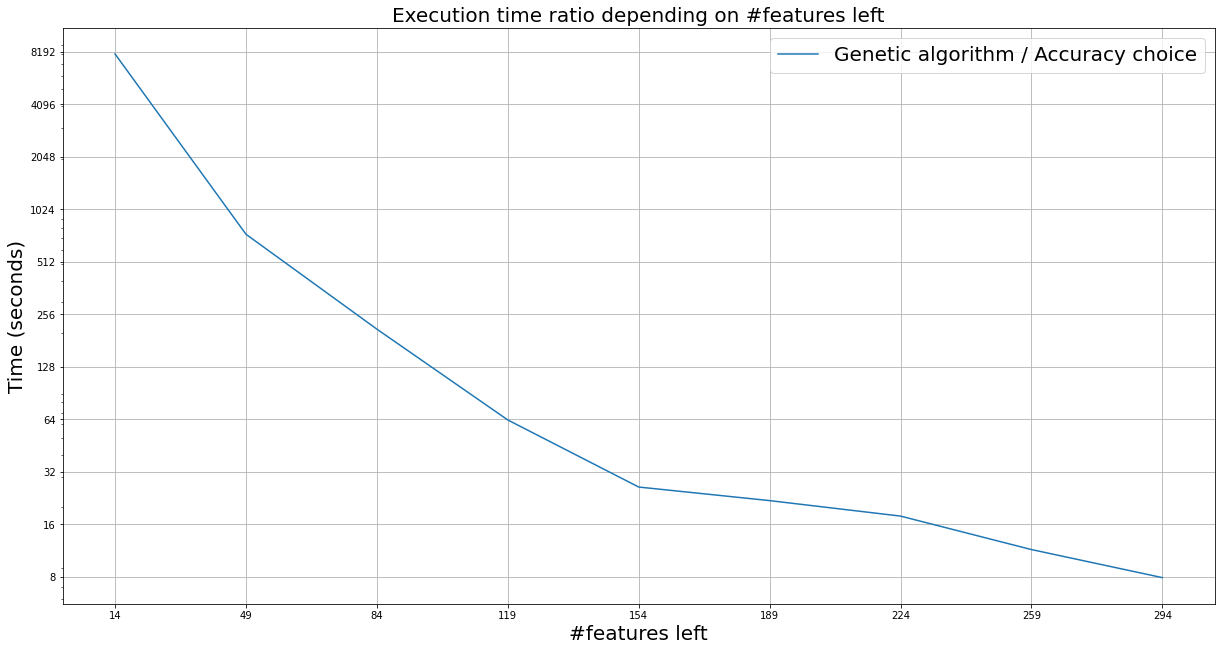

In [200]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_axes([1,1,1,1])
plt.plot(features_counts_last, np.array(gen_times_last) / np.array(logreg_times_last), label = 'Genetic algorithm / Accuracy choice')
plt.legend(loc = 'best', fontsize = 20)
plt.title('Execution time ratio depending on #features left', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Time (seconds)', fontsize = 20)
plt.xticks(features_counts_last)
plt.yscale('log')
plt.yticks([2 ** i for i in range(3, 14)])
ax.set_yticklabels([2 ** i for i in range(3, 14)])
plt.grid()

Как видим, разница разительная. Зато, как мы помним, разница в качестве также очень существенна. И, разумеется, генетический алгоритм всё ещё куда лучше полного перебора.

Напоследок давайте просто взглянем на красивые графики изменения качества популяции для трёх многофазных случаев работы генетического алгоритма (спойлер: они достаточно похожи):

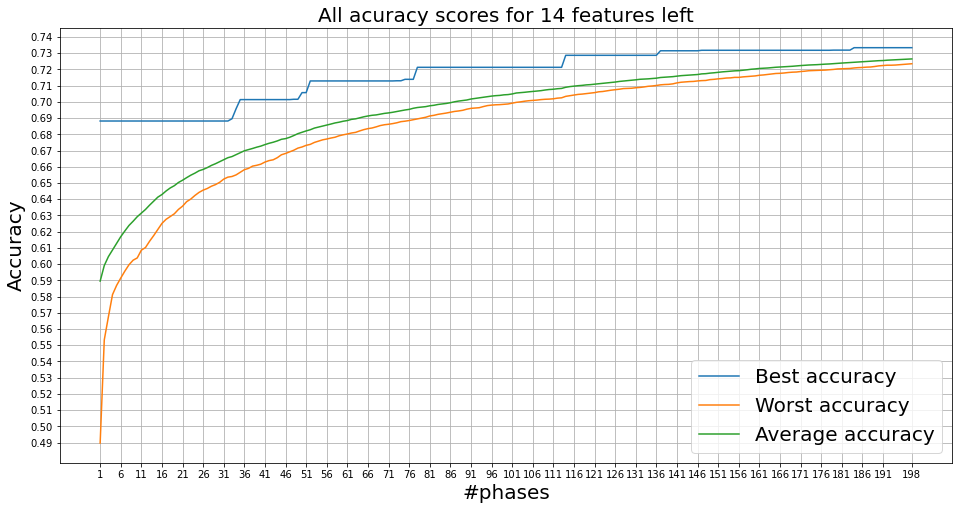

In [28]:
plt.figure(figsize = (16, 8))
plt.plot(range(1, len(gen_max_scores_last[0]) + 1), gen_max_scores_last[0], label = 'Best accuracy')
plt.plot(range(1, len(gen_min_scores_last[0]) + 1), gen_min_scores_last[0], label = 'Worst accuracy')
plt.plot(range(1, len(gen_avg_scores_last[0]) + 1), gen_avg_scores_last[0], label = 'Average accuracy')
plt.title('All acuracy scores for 14 features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#phases', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(list(range(1, len(gen_max_scores_last[0]), 5)) + [len(gen_max_scores_last[0])])
plt.yticks(np.arange(0.49, 0.75, 0.01))
plt.grid()

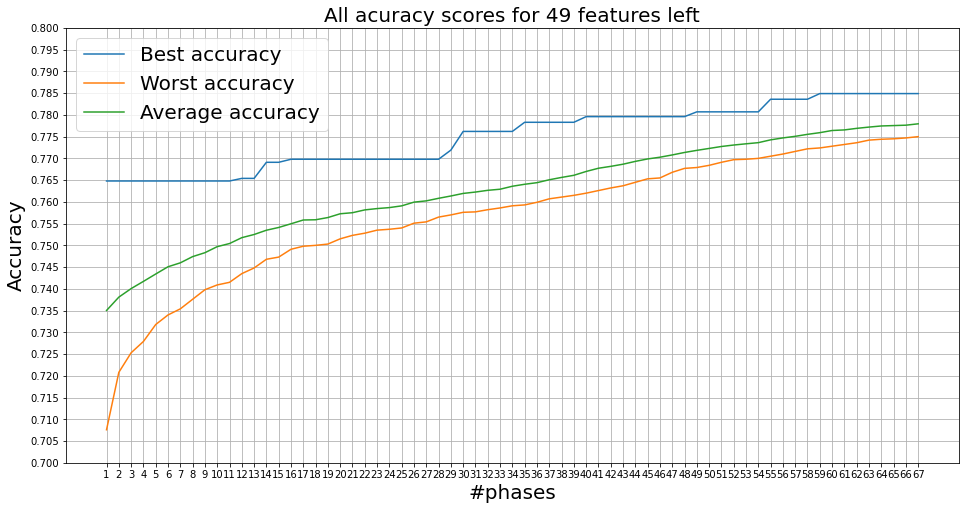

In [43]:
plt.figure(figsize = (16, 8))
plt.plot(range(1, len(gen_max_scores_last[1]) + 1), gen_max_scores_last[1], label = 'Best accuracy')
plt.plot(range(1, len(gen_min_scores_last[1]) + 1), gen_min_scores_last[1], label = 'Worst accuracy')
plt.plot(range(1, len(gen_avg_scores_last[1]) + 1), gen_avg_scores_last[1], label = 'Average accuracy')
plt.title('All acuracy scores for 49 features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#phases', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(range(1, len(gen_max_scores_last[1]) + 1))
plt.yticks(np.arange(0.7, 0.8, 0.005))
plt.grid()

Что интересно, в этот раз мы начали с менее удачной популяции (у лучшей особи на старте точность была ниже 0.77, в отличие от предыдущего поиска для того же числа признаков), но итоговый результат вышел лучше, так что, как видим, стартовая плохая популяция вовсе не обозначает автоматический провал отбора.

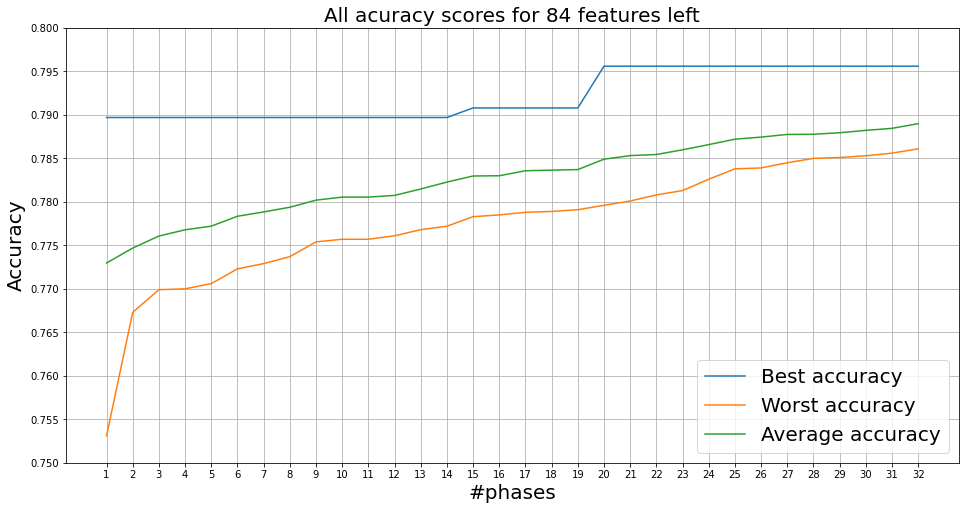

In [114]:
plt.figure(figsize = (16, 8))
plt.plot(range(1, len(gen_max_scores_last[2]) + 1), gen_max_scores_last[2], label = 'Best accuracy')
plt.plot(range(1, len(gen_min_scores_last[2]) + 1), gen_min_scores_last[2], label = 'Worst accuracy')
plt.plot(range(1, len(gen_avg_scores_last[2]) + 1), gen_avg_scores_last[2], label = 'Average accuracy')
plt.title('All acuracy scores for 84 features left', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#phases', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(range(1, len(gen_max_scores_last[2]) + 1))
plt.yticks(np.arange(0.75, 0.8, 0.005))
plt.grid()

Давайте схематично изобразим прирост качества по сравнению с быстрым отбором относительно прироста времени (возьмём от него логарифм, чтобы было покрасивее):

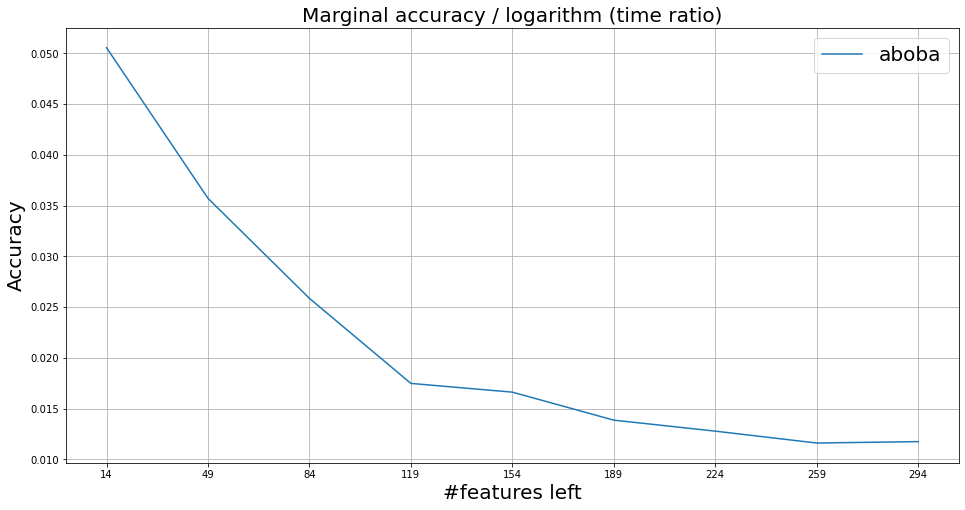

In [203]:
plt.figure(figsize = (16, 8))
aboba = (np.array(best_last) / np.array(logreg_scores_last) - 1) / np.log(np.array(gen_times_last) / np.array(logreg_times_last))
plt.plot(features_counts_last, aboba, label = 'aboba')
plt.title('Marginal accuracy / logarithm (time ratio)', fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel('#features left', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(features_counts_last)
plt.grid()

Небольшое колебание в центре вызвано нестабильностью времени работы быстрого метода отбора признаков, а так в целом зависимость в таких координатах, возможно, можно описать экспоненциальной функцией. Как видим, на меньшем числе признаков наш "выигрыш", измеренный таким спорным способом, выше (впрочем, если делить просто на соотношение времени, а не его логарифм, ситуация будет обратной).

### Выводы

Генетический алгоритм требует гораздо большее время работы, но показывает гораздо более хорошие результаты. Эта разница растёт по мере уменьшения числа/доли признаков, которые мы хотим оставить. Спасибо за внимание, и помните:

<img src = https://i.redd.it/7vdwstivz2f21.png>